In [ ]:
# import statements
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn as sk
import itertools
import warnings
from sklearn import datasets, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV

# Task 1: Data preprocessing

## Dataset 1: IMDB Reviews

Load Data

In [ ]:
%%capture
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xvzf aclImdb_v1.tar.gz

In [ ]:
def fetchdata(path):
  file_names = os.listdir(path)
  file_name_and_text = {}
  for file in file_names:
    with open(path + file, "r") as target_file:
         file_name_and_text[file] = target_file.read().lower()
  file_data = (pd.DataFrame.from_dict(file_name_and_text, orient='index')
             .reset_index().rename(index = str, columns = {'index': 'file_name', 0: 'review'}))
  process_file_name(file_data)
  return file_data.set_index('index').sort_index()

def process_file_name(df):
  def process_index(row):
    return int(row['file_name'].split('_')[0])
    
  def process_rating(row):
    return int(row['file_name'][:-4].split('_')[1])
  
  df['index'] = df.apply(lambda row: process_index(row), axis=1)
  df['rating'] = df.apply(lambda row: process_rating(row), axis=1)

df_train_p = fetchdata('aclImdb/train/pos/')
df_train_p['label'] = 1
df_train_n = fetchdata('aclImdb/train/neg/')
df_train_n['label'] = 0
df_test_p = fetchdata('aclImdb/test/pos/')
df_test_p['label'] = 1
df_test_n = fetchdata('aclImdb/test/neg/')
df_test_n['label'] = 0
df_train = pd.concat([df_train_p, df_train_n], ignore_index=True)
df_test = pd.concat([df_test_p, df_test_n], ignore_index=True)

In [ ]:
with open('aclImdb/imdb.vocab') as f:
    vocab = f.read().splitlines()
df_vocab = pd.DataFrame({'vocab': vocab})

In [ ]:
def process_bow(file_name):
  with open(file_name) as f:
    label = f.read().splitlines()
  rate = []
  bow = []
  for i in label:
    if i[1] == ' ':
      rate.append(i[0])
      bow.append(' '+i[2:]+' ')
    else:
      rate.append(i[:2])
      bow.append(' '+i[3:]+' ')
  df_label = pd.DataFrame({'Bow': bow})
  df_label['rate'] = rate
  return df_label

In [ ]:
df_train_label = process_bow('aclImdb/train/labeledBow.feat')

In [ ]:
df_test_label = process_bow('aclImdb/test/labeledBow.feat')

Filter out stopwords and rare words

In [ ]:
# count occurrences for training set
total_train = {}
for index in range(len(df_train_label)):
  line =  df_train_label.loc[index,'Bow']
  index_pos_list = [ i for i in range(len(line)) if line[i] == ':' ]
  list_blank = [ i for i in range(len(line)) if line[i] == ' ' ]
  for j in range(len(index_pos_list)):
    num = int(line[list_blank[j]+1:index_pos_list[j]])
    if num in total_train.keys():
      total_train[num] += 1
    else:
      total_train[num] = 1
total_train = dict(sorted(total_train.items()))
train_word = pd.DataFrame(total_train.values(), index = total_train.keys(),columns = ['train'])
train_word

,train
0,24792
1,24162
2,24173
3,23722
4,23459
...,...
89522,1
89523,1
89524,1
89525,1


In [ ]:
# count occurrences for test set
total_test = {}
for index in range(len(df_test_label)):
  line =  df_test_label.loc[index,'Bow']
  index_pos_list = [ i for i in range(len(line)) if line[i] == ':' ]
  list_blank = [ i for i in range(len(line)) if line[i] == ' ' ]
  for j in range(len(index_pos_list)):
    num = int(line[list_blank[j]+1:index_pos_list[j]])
    if num in total_test.keys():
      total_test[num] += 1
    else:
      total_test[num] = 1
total_test = dict(sorted(total_test.items()))
test_word = pd.DataFrame(total_test.values(), index = total_test.keys(),columns = ['test'])

In [ ]:
df_total = pd.concat([df_vocab, train_word, test_word], axis = 1)
df_total['train_%'] = df_total['train']/25000
df_process = df_total[(0.01<=df_total['train_%'])&(df_total['train_%'] <= 0.5)]
df_process

,vocab,train,test,train_%
21,he,10308,10010.0,0.41232
23,his,10677,10460.0,0.42708
27,!,8595,8754.0,0.34380
30,by,11689,11600.0,0.46756
31,an,12203,12088.0,0.48812
...,...,...,...,...
1935,continues,252,221.0,0.01008
1938,below,254,272.0,0.01016
1958,opens,250,225.0,0.01000
1967,essentially,250,244.0,0.01000


Calculate z-score

In [ ]:
# X (N*D) = (25000*1744): frequency count of each word for each review. Each row is a review.
filtered_vocab_indices = list(df_process.index.values)
z_score_X = np.zeros((len(df_train), len(df_process)))
print("X shape:", z_score_X.shape)

for index in range(len(df_train_label)):
  freq_count = dict.fromkeys(filtered_vocab_indices, 0) # initialize a dict with each word as key and 0 as value
  line =  df_train_label.loc[index,'Bow']
  tokens = line.split(" ")[1:-1]
  for token in tokens:
    num = int(token.split(":")[0])
    count = int(token.split(":")[1])
    if num in freq_count: 
      freq_count[num] = count # set the count of a word
  z_score_X[index] = list(freq_count.values()) # update the word frequency count for this single review

# y (N*1) = (25000*1): rate for each review.
z_score_y = df_train_label.rate.to_numpy().astype(int)
print("y shape", z_score_y.shape)

X shape: (25000, 1744)
y shape (25000,)


In [ ]:
# standardize X
z_score_X_std = np.zeros((len(df_train), len(df_process)))
for d in range(z_score_X.shape[1]):
  z_score_X_std[:,d] = (z_score_X[:,d] - z_score_X[:,d].mean()) / z_score_X[:,d].std()

# standardize y
z_score_y_std = (z_score_y - z_score_y.mean()) / z_score_y.std()

# z_score (D*1) = (1744*1): z-scores for each word
z_score = z_score_X_std.T.dot(z_score_y_std) / (len(df_train))**0.5

In [ ]:
# Find the most positive and negative words
most_pos_word_indices = np.array(filtered_vocab_indices)[np.argsort(z_score)[::-1]][:10]
most_pos_words = df_process.vocab[most_pos_word_indices]
print("Top 10 most positive words:\n", most_pos_words, "\n")

most_neg_word_indices = np.array(filtered_vocab_indices)[np.argsort(z_score)][:10]
most_neg_words = df_process.vocab[most_neg_word_indices]
print("Top 10 most negative words:\n", most_neg_words, "\n")

print("Absolutely makes sense!")

Top 10 most positive words:
 83         great
369    wonderful
309    excellent
115         best
114         love
459      amazing
437        loved
392      perfect
493     favorite
297    beautiful
Name: vocab, dtype: object 

Top 10 most negative words:
 77          bad
240       worst
427       waste
368       awful
46            ?
373    terrible
422       worse
55           no
503    horrible
363      stupid
Name: vocab, dtype: object 

Absolutely makes sense!


In [ ]:
most_pos_zcore = np.sort(z_score)[::-1][:10]
most_neg_zcore = np.sort(z_score)[:10]
dic = {'Z_score':list(np.append(most_pos_zcore, most_neg_zcore)), 'Word':list(np.append(most_pos_words, most_neg_words))}
top_20 = np.append(most_pos_words, most_neg_words)
score = np.append(most_pos_zcore, most_neg_zcore)
data = pd.DataFrame(dic)

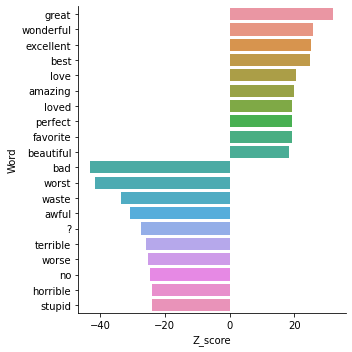

In [ ]:
sn.catplot(x = 'Z_score',y = 'Word', kind = 'bar',data = data)

In [ ]:
# Choose top D features based on z-score
D_value = 150
most_imp_word_indices = np.argsort(np.abs(z_score))[::-1][:D_value]
most_imp_word_original_indices = np.array(filtered_vocab_indices)[most_imp_word_indices]
most_imp_words = df_process.vocab[most_imp_word_original_indices].reset_index(drop=True)
most_imp_words

0             bad
1           worst
2           waste
3           great
4           awful
          ...    
145           job
146       awesome
147        strong
148    definitely
149    incredible
Name: vocab, Length: 150, dtype: object

Process Training Set

In [ ]:
# We only keep the most important features in X
X1_train_raw = z_score_X[:,most_imp_word_indices]

# y is the 0/1 labels
y1_train_raw = df_train.label

Process Test Set

In [ ]:
# We only keep the most important features in X
X1_test = np.zeros((len(df_test), D_value))

for index in range(len(df_test_label)):
  freq_count = dict.fromkeys(most_imp_word_original_indices, 0) # initialize a dict with each word as key and 0 as value
  line =  df_test_label.loc[index,'Bow']
  tokens = line.split(" ")[1:-1]
  for token in tokens:
    num = int(token.split(":")[0])
    count = int(token.split(":")[1])
    if num in freq_count:
      freq_count[num] = count # set the count of a word
  X1_test[index] = list(freq_count.values())

# y is the 0/1 labels
y1_test = df_test.label

## Dataset 2: 20 news groups

Load data

In [ ]:
categories = ['comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian']
train = datasets.fetch_20newsgroups(subset='train',categories=categories, remove=(['headers','footers','quotes']))
test = datasets.fetch_20newsgroups(subset='test',categories=categories, remove=(['headers','footers','quotes']))

In [ ]:
target_train = train.target
target_test = test.target

def one_hot_encoding(target):
  df_target = pd.DataFrame(index = range(len(target)),columns = [0, 1, 2, 3])
  for i in range(len(target)):
    if target[i] == 0:
      df_target.loc[i,0] = 1
      df_target.loc[i,1] = 0
      df_target.loc[i,2] = 0
      df_target.loc[i,3] = 0
    elif target[i] == 1:
      df_target.loc[i,0] = 0
      df_target.loc[i,1] = 1
      df_target.loc[i,2] = 0
      df_target.loc[i,3] = 0
    elif target[i] == 2:
      df_target.loc[i,0] = 0
      df_target.loc[i,1] = 0
      df_target.loc[i,2] = 1
      df_target.loc[i,3] = 0
    else:
      df_target.loc[i,0] = 0
      df_target.loc[i,1] = 0
      df_target.loc[i,2] = 0
      df_target.loc[i,3] = 1
  return df_target

df_target_train = one_hot_encoding(target_train)
df_target_test = one_hot_encoding(target_test)
print(df_target_train)

      0  1  2  3
0     0  0  1  0
1     0  0  0  1
2     1  0  0  0
3     0  0  1  0
4     1  0  0  0
...  .. .. .. ..
2372  1  0  0  0
2373  0  1  0  0
2374  0  0  1  0
2375  0  1  0  0
2376  0  0  0  1

[2377 rows x 4 columns]


In [ ]:
count_vect = CountVectorizer().fit(train.data)
X_train_counts = count_vect.transform(train.data)
X_test_counts = count_vect.transform(test.data)

Filter out rare words and stopwords

In [ ]:
total_counts = np.count_nonzero(X_train_counts.toarray(), axis=0)
df = pd.DataFrame(total_counts, columns = ['frequency'])
df['percent'] = df.frequency/X_train_counts.shape[0]

In [ ]:
df.sort_values('frequency')

,frequency,percent
15472,1,0.000421
17342,1,0.000421
17341,1,0.000421
17340,1,0.000421
17338,1,0.000421
...,...,...
14773,1606,0.675642
20027,1731,0.728229
3616,1738,0.731174
28066,1857,0.781237


In [ ]:
df = df[(df['percent'] <= 0.5) & (df['percent'] >= 0.01)]
df

,frequency,percent
0,48,0.020194
1,36,0.015145
133,151,0.063525
134,62,0.026083
271,107,0.045015
...,...,...
30820,1028,0.432478
30822,53,0.022297
30828,478,0.201094
30831,26,0.010938


Calculate Mutual Information

In [ ]:
filter_out_ind = list(df.index.values)
MI_x = X_train_counts[:,filter_out_ind].toarray()

In [ ]:
MI_x_std = np.zeros((MI_x.shape[0], len(filter_out_ind)))
for d in range(MI_x.shape[1]):
  MI_x_std[:,d] = (MI_x[:,d] - MI_x[:,d].mean())/MI_x[:,d].std()

In [ ]:
warnings.filterwarnings("ignore")
dic = {}
i = 0
while i < 4:
  score = []
  for j in range(MI_x_std.shape[1]):
    M = metrics.mutual_info_score(MI_x_std[:,j], np.asarray(df_target_train[i]))
    score.append(M)
  dic[i] = score
  i += 1
df_MI = pd.DataFrame(dic)
df_MI

,0,1,2,3
0,0.002133,0.005345,0.003038,0.002733
1,0.001453,0.002367,0.002388,0.001916
2,0.005320,0.013609,0.005454,0.003288
3,0.003083,0.003137,0.002206,0.002246
4,0.002709,0.011882,0.006512,0.004705
...,...,...,...,...
1581,0.014360,0.011140,0.009210,0.034381
1582,0.004811,0.002790,0.001591,0.002294
1583,0.010640,0.010181,0.004506,0.018184
1584,0.000759,0.000896,0.000527,0.003262


In [ ]:
y0 = df_MI.sort_values(0, ascending = False)
word_y0 = list(y0.index.values)[:100]
y1 = df_MI.sort_values(1, ascending = False)
word_y1 = list(y1.index.values)[:100]
y2 = df_MI.sort_values(2, ascending = False)
word_y2 = list(y2.index.values)[:100]
y3 = df_MI.sort_values(3, ascending = False)
word_y3 = list(y3.index.values)[:100]

feature = sorted(word_y0+word_y1+word_y2+word_y3)
feature_final = np.unique(np.array(feature))

Top features based on Mutual Information

In [ ]:
names_ = count_vect.get_feature_names()
group = {0:word_y0,1:word_y1,2:word_y2,3:word_y3}
feature = {}
for i in range(4):
  top_word = []
  g = group[i]
  for j in range(20):
    w = names_[np.array(filter_out_ind)[g[j]]]
    top_word.append(w)
  feature[categories[i]]=top_word
feature = pd.DataFrame(feature)
feature

,comp.graphics,rec.sport.hockey,sci.med,soc.religion.christian
0,graphics,team,banks,god
1,he,game,gordon,jesus
2,who,hockey,geb,christ
3,files,season,chastity,bible
4,file,nhl,n3jxp,christians
5,his,play,dsl,church
6,image,players,shameful,christian
7,3d,games,cadre,we
8,god,league,intellect,not
9,program,teams,surrender,faith


Process training set

In [ ]:
final_kept_indices = np.array(filter_out_ind)[feature_final]
X2_train_raw = X_train_counts.toarray()[:,final_kept_indices]
print(f"X dimension: {X2_train_raw.shape}")

y2_train_raw = df_target_train.to_numpy()
print(f"y dimension: {y2_train_raw.shape}")

X dimension: (2377, 297)
y dimension: (2377, 4)


Process test set

In [ ]:
X2_test = X_test_counts.toarray()[:,final_kept_indices]
print(f"X dimension: {X2_test.shape}")

y2_test = df_target_test.to_numpy()
print(f"y dimension: {y2_test.shape}")

X dimension: (1582, 297)
y dimension: (1582, 4)


# Task 2: Implement Logistic and Multiclass classifiers

## Logistic Regression

In [ ]:
logistic = lambda z: 1/ (1 + np.exp(-z))       #logistic function

class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.ce_all = []

    def ce(self, x, y):
        a = np.dot(x, self.w)
        return np.mean(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a)))

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            self.ce_all.append(self.ce(x, y)) # cross-entropy
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh
        
    def check_grad(self, x, y):
        N, D = x.shape

        w = np.random.randn(D,1)
        w0 = w

        epsilon = np.random.rand() * 1e-4

        w1 = w0 + epsilon
        w2 = w0 - epsilon
        a1 = np.matmul(x, w1)
        a2 = np.matmul(x, w2)

        ce1 = np.matmul(y, np.log1p(np.exp(-a1))) + np.matmul((1-y), np.log1p(np.exp(a1)))
        ce2 = np.matmul(y, np.log1p(np.exp(-a2))) + np.matmul((1-y), np.log1p(np.exp(a2)))
        dw_num = (ce1 - ce2)/(2*epsilon) # approximated gradient

        x_row = x.sum(axis = 1)
        yh = logistic(np.matmul(x, w))    # predictions  size N
        grad = np.dot(x_row, (yh.transpose()[0] - y))
        dw_cal = grad
        print(np.sum(np.square(dw_cal - dw_num)/np.square(dw_cal + dw_num)))

## Multiclass Classification

In [ ]:

class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)
        self.epsilon = 1e-4

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.0025, max_iters=1000):
        losses_train = np.zeros(max_iters)
        losses_valid = np.zeros(max_iters)
        g = np.inf
        t = 0
        while np.linalg.norm(g) > self.epsilon and t < max_iters:
            g = self.grad(X, y)
            self.W = self.W - lr * g
            loss_train = self.ce(X, y)
            losses_train[t] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[t] = loss_valid
            t += 1
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        return diff.sum()

## Evaluate Model Accuracy

For Logistic Regression

In [ ]:
def evaluate_acc(y_test_pred, y_test):
  return np.sum(y_test_pred == y_test) / y_test.shape[0]

For Multiclass Classification

In [ ]:
def evaluate(y, y_pred):
  accuracy = (y_pred.argmax(axis=1) == y.argmax(axis=1)).sum()
  accuracy = accuracy / y.shape[0]
  return accuracy

# Task 3: Run experiments

## Dataset 1: IMDB Reviews

1. Learning rate hyperparameter tuning - We chose α=0.1 based on accuracy

In [ ]:
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train_raw, y1_train_raw, test_size=0.3, shuffle=True, random_state=42)

In [ ]:
logistic_model_0_05 = LogisticRegression(verbose=False, add_bias=False, max_iters=10000, learning_rate=0.05).fit(X1_train, y1_train)

In [ ]:
logistic_model_0_1 = LogisticRegression(verbose=False, add_bias=False, max_iters=10000, learning_rate=0.1).fit(X1_train, y1_train)

In [ ]:
logistic_model_0_25 = LogisticRegression(verbose=False, add_bias=False, max_iters=10000, learning_rate=0.25).fit(X1_train, y1_train)

In [ ]:
logistic_model_0_5 = LogisticRegression(verbose=False, add_bias=False, max_iters=10000, learning_rate=0.5).fit(X1_train, y1_train)

In [ ]:
print("Accuracy on the validation set")
for logistic_model in [logistic_model_0_05, logistic_model_0_1, logistic_model_0_25, logistic_model_0_5]:
  y1_val_pred = logistic_model.predict(X1_val)
  y1_val_pred = (y1_val_pred > 0.5).astype(int)
  print(f"--Learning rate: {logistic_model.learning_rate}, Accuracy: {evaluate_acc(y1_val_pred, y1_val)}")

y1_test_pred = logistic_model_0_1.predict(X1_test)
y1_test_pred = (y1_test_pred > 0.5).astype(int)
y1_train_pred = logistic_model_0_1.predict(X1_train)
y1_train_pred = (y1_train_pred > 0.5).astype(int)

print(f"\nTraining set accuracy with learning rate 0.1: {evaluate_acc(y1_train_pred, y1_train)}")
print(f"Test set accuracy with learning rate 0.1: {evaluate_acc(y1_test_pred, y1_test)}")
print("No overfitting detected.")

Accuracy on the validation set
--Learning rate: 0.05, Accuracy: 0.8374666666666667
--Learning rate: 0.1, Accuracy: 0.84
--Learning rate: 0.25, Accuracy: 0.8390666666666666
--Learning rate: 0.5, Accuracy: 0.8394666666666667

Training set accuracy with learning rate 0.1: 0.8433142857142857
Test set accuracy with learning rate 0.1: 0.84124
No overfitting detected.


2. LASSO and Ridge

In [ ]:
log = LogisticRegressionCV(cv=5, random_state=0).fit(X1_train_raw, y1_train_raw)
auc = cross_val_score(log, X1_test, y1_test, cv=5, scoring='roc_auc')
print(f"\Test set AUCROC_score with no regularization: {auc.mean()}")

ridge = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1],cv = 5).fit(X1_train_raw, y1_train_raw)
aucr = cross_val_score(ridge, X1_test, y1_test, cv=5, scoring='roc_auc')
print(f"\Test set AUCROC_score with Ridge regularization: {aucr.mean()}")

lasso = LogisticRegressionCV(class_weight= 'balanced', penalty= 'l1', solver= 'liblinear',random_state=42)
scores = cross_val_score(lasso,X1_test,y1_test,cv=5,scoring='roc_auc',n_jobs=-1)
print(f"\Test set AUCROC_score LASSO regularization: {scores.mean()}")

\Test set AUCROC_score with no regularization: 0.9181784159999999
\Test set AUCROC_score with Ridge regularization: 0.915611088
\Test set AUCROC_score LASSO regularization: 0.9183625120000001


3. Check gradient using small perturbation

In [ ]:
logistic_model_grad = LogisticRegression(verbose=False, add_bias=False, max_iters=10000, learning_rate=0.1)
logistic_model_grad.check_grad(X1_train, y1_train)

1.3262475746154258e-17


4. Convergence plot on how the logistic regression converge given the best learning rate of 0.1.

<Figure size 432x288 with 0 Axes>

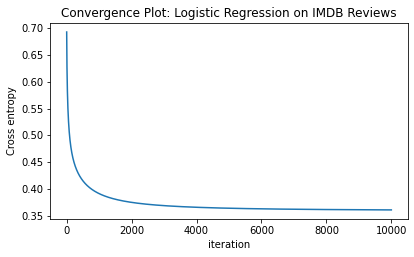

In [ ]:
plt.clf()
plt.figure(figsize=((16/9)*3.6,3.6))
plt.plot(logistic_model_0_1.ce_all)
plt.ylabel("Cross entropy")
plt.xlabel("iteration")
plt.title("Convergence Plot: Logistic Regression on IMDB Reviews")
plt.show()

5. A single plot containing two ROC curves of logistic regression and sklearn-KNN on the IMDB test data

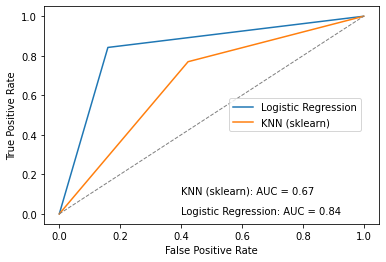

In [ ]:
def plot_roc(models):
  perf = {}

  for model_name, data in models.items():
      y_test, y_test_prob = data
      # compute ROC and AUROC
      fpr, tpr, _ = roc_curve(y_test, y_test_prob)
      auroc = roc_auc_score(y_test, y_test_prob)
      perf[model_name] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
  
  plt.clf()
  i = 0
  for model_name, model_perf in perf.items():
      plt.plot(model_perf['fpr'], model_perf['tpr'],
              label=model_name)
      plt.text(0.4, i, model_name + ': AUC = '+
              str(round(model_perf['auroc'],2)))
      i += 0.1

  plt.plot((0, 1), (0, 1), linestyle="--", lw=1, color='gray')
  plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.6))
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.show()


KNN = KNeighborsClassifier(n_neighbors = 3).fit(X1_train, y1_train)
y1_test_pred_knn = KNN.predict(X1_test)
models_data = {"Logistic Regression": (y1_test, y1_test_pred), "KNN (sklearn)": (y1_test, y1_test_pred_knn)}
plot_roc(models_data)

6. A bar plot that shows the AUROC of logistic regression and KNN on the test data (y-axis) as a function of the 20%, 40%, 60%, 80%, and 100% training data (x-axis)

In [ ]:
# prepare certain proportions of training data
data_proportion = [20, 40, 60, 80, 100]
training_data = {}
for prop in data_proportion:
  if prop < 100:
    _, X1_train_part, _, y1_train_part = train_test_split(X1_train, y1_train, test_size=prop*0.01, shuffle=True, random_state=111)
    training_data[prop] = X1_train_part, y1_train_part
  else:
    training_data[prop] = X1_train, y1_train

# calculate AUROC of logistic regression
auroc_logistic = []
for prop in data_proportion:
  X1_train_part, y1_train_part = training_data[prop]
  logistic_model = LogisticRegression(verbose=False, add_bias=False, max_iters=10000, learning_rate=0.1).fit(X1_train_part, y1_train_part)
  y1_test_pred_logistic = logistic_model.predict(X1_test)
  y1_test_pred_logistic = (y1_test_pred_logistic > 0.5).astype(int)
  auroc_logistic.append(roc_auc_score(y1_test, y1_test_pred_logistic))
auroc_logistic

[0.8334400000000001,
 0.8380000000000001,
 0.8421200000000001,
 0.8412400000000001,
 0.84124]

In [ ]:
# calculate AUROC of KNN
auroc_knn = []
for prop in data_proportion:
  X1_train_part, y1_train_part = training_data[prop]
  KNN = KNeighborsClassifier(n_neighbors = 3).fit(X1_train_part, y1_train_part)
  y1_test_pred_knn = KNN.predict(X1_test)
  y1_test_pred_knn = (y1_test_pred_knn > 0.5).astype(int)
  auroc_knn.append(roc_auc_score(y1_test, y1_test_pred_knn))
auroc_knn

[0.64688, 0.6563599999999999, 0.6639999999999999, 0.67056, 0.67344]

<Figure size 432x288 with 0 Axes>

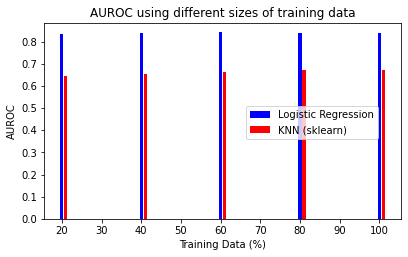

In [ ]:
# plot AUROC of logistic regression and KNN
plt.clf()
plt.figure(figsize=((16/9)*3.6,3.6))
plt.bar(data_proportion, auroc_logistic, color="b", label="Logistic Regression")
plt.bar([x+1 for x in data_proportion], auroc_knn, color="r", label="KNN (sklearn)")
plt.ylabel("AUROC")
plt.xlabel("Training Data (%)")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.6))
plt.title("AUROC using different sizes of training data")
plt.show()

7. A horizontal bar plot showing the top 20 features (10 most positive and 10 most negative) from the logistic regression on the IMDB data with the coefficient as the x-axis and the feature names (i.e., words) as the y-axis

In [ ]:
effect_size = logistic_model_0_1.w[:(len(logistic_model_0_1.w)-1)]

In [ ]:
most_pos = np.sort(effect_size)[::-1][:10]
most_neg = np.sort(effect_size)[:10]
pos_words = most_imp_words[np.argsort(effect_size)[::-1][:10]]
neg_words = most_imp_words[np.argsort(effect_size)[:10]]

coef = {'Coefficient':list(np.append(most_pos, most_neg)), 'Word':list(np.append(pos_words, neg_words))}
data_coeff = pd.DataFrame(coef)
data_coeff

,Coefficient,Word
0,1.087426,superb
1,1.082066,excellent
2,0.981389,perfect
3,0.966864,favorite
4,0.880535,fantastic
5,0.861145,wonderfully
6,0.828508,amazing
7,0.795562,masterpiece
8,0.794456,wonderful
9,0.794336,perfectly


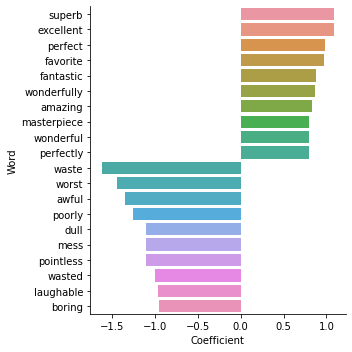

In [ ]:
sn.catplot(x = 'Coefficient',y = 'Word', kind = 'bar',data = data_coeff)

## Dataset 2: 20 news groups

1. Check gradient using small perturbation



In [ ]:
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train_raw, y2_train_raw, test_size=0.3, shuffle=True, random_state=11)
X2_train, X2_val, y2_train, y2_val = X2_train.astype('float128'), X2_val.astype('float128'), y2_train.astype('float128'), y2_val.astype('float128')

In [ ]:
D = X2_train.shape[1]
C = y2_train.shape[1]
mlr = Multinomial_logistic(D, C)

In [ ]:
print(mlr.check_grad(X2_train, y2_train))

2.941441905506209e-14


2. Convergence plot on how the multiclass regression converge with α=0.00025

In [ ]:
D = X2_train.shape[1]
C = y2_train.shape[1]
mlr = Multinomial_logistic(D, C)
ce_train, ce_valid = mlr.fit(X2_train, y2_train, X2_val, y2_val, lr=0.00025, max_iters=1000)

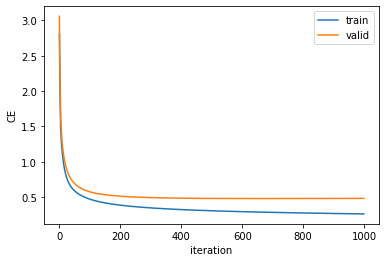

In [ ]:
plt.clf()
plt.plot(ce_train/X2_train.shape[0], label='train')
plt.plot(ce_valid/X2_val.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
plt.show()

3. A bar plot that shows the accuracy of multiclass regression and KNN on the test data (y-axis) as a function of the 20%, 40%, 60%, 80%, and 100% training data (x-axis)

In [ ]:
# prepare certain proportions of training data
data_proportion = [20, 40, 60, 80, 100]
training_data = {}
for prop in data_proportion:
  if prop < 100:
    _, X2_train_part, _, y2_train_part = train_test_split(X2_train, y2_train, test_size=prop*0.01, shuffle=True, random_state=111)
    training_data[prop] = X2_train_part, y2_train_part
  else:
    training_data[prop] = X2_train, y2_train

# calculate accuracy of multiclass regression
accuracy = []
for prop in data_proportion:
  X2_train_part, y2_train_part = training_data[prop]
  D = X2_train_part.shape[1]
  C = y2_train_part.shape[1]
  multiclass_model = Multinomial_logistic(D,C)
  multiclass_model.fit(X2_train_part, y2_train_part, lr = 0.0005)
  y2_test_pred_multiclass = multiclass_model.predict(X2_test)
  accuracy.append(evaluate(y2_test, y2_test_pred_multiclass))
accuracy

[0.6984829329962073,
 0.7629582806573957,
 0.7730720606826802,
 0.7781289506953224,
 0.7907711757269279]

In [ ]:
# calculate accuracy of KNN
accuracy_knn = []
for prop in data_proportion:
  X2_train_part, y2_train_part = training_data[prop]
  knn_model = KNeighborsClassifier(n_neighbors = 3)
  knn_model.fit(X2_train_part, y2_train_part)
  y2_test_pred_knn = knn_model.predict(X2_test)
  accuracy_knn.append(evaluate(y2_test, y2_test_pred_knn))
accuracy_knn

[0.4424778761061947,
 0.4683944374209861,
 0.48166877370417194,
 0.4823008849557522,
 0.49557522123893805]

<Figure size 432x288 with 0 Axes>

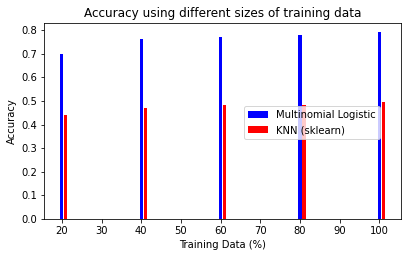

In [ ]:
# plot accuracy of multiclass logistic regression and KNN
plt.clf()
plt.figure(figsize=((16/9)*3.6,3.6))
plt.bar(data_proportion, accuracy, color ="b", label="Multinomial Logistic")
plt.bar([x + 1 for x in data_proportion], accuracy_knn, color="r", label="KNN (sklearn)")
plt.ylabel("Accuracy")
plt.xlabel("Training Data (%)")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.6))
plt.title("Accuracy using different sizes of training data")
plt.show()

4. A heatmap showing the top 5 most positive features as rows for each class as columns in the multi-class classification on 4 the chosen classes from the 20-news group datasets.

In [ ]:
g1, g2, g3, g4 = [], [], [], []
s1, s2, s3, s4 = [], [], [], []
for i in range(297):
  s1.append(mlr.W[i][0])
  s2.append(mlr.W[i][1])
  s3.append(mlr.W[i][2])
  s4.append(mlr.W[i][3])
for i in range(297):
  g1.append(mlr.W[i][0])
  g2.append(mlr.W[i][1])
  g3.append(mlr.W[i][2])
  g4.append(mlr.W[i][3])
g1.sort()
g2.sort()
g3.sort()
g4.sort()
g1.reverse()
g2.reverse()
g3.reverse()
g4.reverse()

index_l1 = []
index_l2 = []
index_l3 = []
index_l4 = []

#compute the index from feature_final to filter_out_ind
for i in range(20):
  for j in range(297):
    if s1[j] == g1[i]:
      index_l1.append(feature_final[j])
    if s2[j] == g2[i]:
      index_l2.append(feature_final[j])
    if s3[j] == g3[i]:
      index_l3.append(feature_final[j])
    if s4[j] == g4[i]:
      index_l4.append(feature_final[j])

#find the original word
for i in range(20):
  index_l1[i] = names_[filter_out_ind[index_l1[i]]]
  index_l2[i] = names_[filter_out_ind[index_l2[i]]]
  index_l3[i] = names_[filter_out_ind[index_l3[i]]]
  index_l4[i] = names_[filter_out_ind[index_l4[i]]]


In [ ]:
mul_dict = {'comp.graphics':index_l1, 'rec.sport.hockey':index_l2, 'sci.med':index_l3, 'soc.religion.christian':index_l4} 
mul_feature = pd.DataFrame(mul_dict)
mul_feature

,comp.graphics,rec.sport.hockey,sci.med,soc.religion.christian
0,graphics,team,disease,church
1,files,hockey,msg,bible
2,images,game,cancer,god
3,3d,games,syndrome,christ
4,image,play,treatment,heaven
5,code,season,food,jesus
6,computer,win,blood,christians
7,looking,toronto,cause,christian
8,algorithm,playoff,banks,word
9,file,montreal,sci,christianity


In [ ]:
word1 = []
word2 = []
word3 = []
word4 = []
word1_j, word2_j, word3_j, word4_j = [], [], [], []

for i in range(20):
  for j in range(296):
    if s1[j] == g1[i]:
      word1.append(filter_out_ind[feature_final[j]])
      word1_j.append(j)
    if s2[j] == g2[i]:
      word2.append(filter_out_ind[feature_final[j]])
      word2_j.append(j)
    if s3[j] == g3[i]:
      word3.append(filter_out_ind[feature_final[j]])
      word3_j.append(j)
    if s4[j] == g4[i]:
      word4.append(filter_out_ind[feature_final[j]])
      word4_j.append(j)


map = [[0]*4]*20
frac = [0,0,0,0]
for i in range(20):
  frac = [df.loc[word1[i]].at["percent"],df.loc[word2[i]].at["percent"],df.loc[word3[i]].at["percent"],df.loc[word4[i]].at["percent"]]
  map[i] = frac


In [ ]:
# words from the four classes
words = []
for j in range(5):
  words.append(index_l1[j])

for j in range(5):
  words.append(index_l2[j])

for j in range(5):
  words.append(index_l3[j])

for j in range(5):
  words.append(index_l4[j])

# four sets
columns = ["comp.graphics", "rec.sport.hockey","sci.med","soc.religion.christian"]

map = [[0]*4]*20
frac = [0,0,0,0]
for i, word in enumerate(words):
  label = i // 5
  word_ind = -1
  if label == 0:
    word_ind = word1_j[i % 5]
  elif label == 1:
    word_ind = word2_j[i % 5]
  elif label == 2:
    word_ind = word3_j[i % 5]
  else:
    word_ind = word4_j[i % 5]
  frac = mlr.W[word_ind]
  map[i] = frac

heatdf = pd.DataFrame(map, columns=columns, index=words)

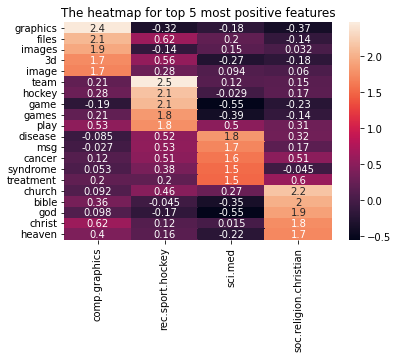

In [ ]:
plt.clf()
plt.ylabel("4 chosen classes")
plt.xlabel("20-news group")
sn.heatmap(heatdf,annot=True,)
plt.title("The heatmap for top 5 most positive features")

plt.show()

5. LASSO and Ridge

In [ ]:
mul = LogisticRegressionCV( multi_class = 'ovr', solver= 'saga', random_state=0).fit(X2_train_raw, target_train)
accn = cross_val_score(mul, X2_test, target_test, cv = 5, scoring='accuracy')
print(f"\Test set accuracy with no regularization: {accn.mean()}")

ridge_m = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv = 5).fit(X2_train_raw, target_train)
accr = cross_val_score(ridge_m, X2_test, target_test, cv = 5, scoring='accuracy')
print(f"\Test set accuracy with Ridge regularization: {accr.mean()}")

lasso_m = LogisticRegressionCV(class_weight= 'balanced', penalty= 'l1', solver= 'saga', multi_class = 'ovr', random_state=42).fit(X2_train_raw, target_train)
scores_l = cross_val_score(lasso_m,X2_test,target_test, cv=5,scoring='accuracy',n_jobs=-1)
print(f"\Test set accuracy LASSO regularization: {scores_l.mean()}")


\Test set accuracy with no regularization: 0.7674040650081858
\Test set accuracy with Ridge regularization: 0.6479155851934673
\Test set accuracy LASSO regularization: 0.7496965219821907
